In [14]:
# -*- coding: utf-8 -*-
"""
Created on Thu May 11 13:28:17 2017
Zernike Moments in Python, OpenCV and Mahotas
@author: tsrivas
"""
# import the necessary packages
import mahotas

class ZernikeMoments():
    def __init__(self,radius):
        # store the size of the radius that will be used when computing
        # moments
        self.radius=radius
        
    def describe(self,image):
        # return the Zernike moments for an image
        return mahotas.features.zernike_moments(image,self.radius)

In [20]:
# -*- coding: utf-8 -*-
%matplotlib inline
"""
Created on Thu May 11 13:40:22 2017
Indexing Pokemon Sprites in Python, OpenCV and mahotas
@author: tsrivas
"""
# import the necessary packages
from Zernike_Moments import ZernikeMoments
import numpy as np
import cv2
import argparse
import cPickle
import glob

# construct the argument parser
# ap=argparse.ArgumentParser()
# ap.add_argument("-s","--sprites", required = True,
#                 help = 'Path to where the sprites are stored')
# ap.add_argument("-i","--index", required = True,
#                 help = 'Path to where the indexed images are stored')
# args=vars(ap.parse_args())

# initialize our descriptor (Zernike Moments with a radius of 21 
# used to characterize the shape of our pokemon) and our index dictionary

desc = ZernikeMoments(21)
index = {}

# Now we have to index our images (pokemon sprites)
# loop over the sprite images
for spritePath in glob.glob("C:\Users\tsrivas\Documents\PythonScripts\PyImage Blogs\Pokemon Image Search\sprites"+ "/*.png"):
    
    # parse out the pokemon name, then load the image
    # then convert it to grayscale
    # the pokemon name will be used as the key in the index dictionary
    pokemon = spritePath[spritePath.rfind("/") + 1:].replace(".png","")
    image = cv2.imread(spritePath)
    print spritePath
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # pad the image with extra white pixels, so the edges of
    # the pokemon are not up against the borders of the image.
    image = cv2.copyMakeBorder(image, 15, 15, 15, 15,
                               cv2.BORDER_CONSTANT, value = 255)
        
    # invert the image and threshold it
    thresh = cv2.bitwise_not(image)
    thresh[thresh > 0] = 255
        
    # initialize the outline image, find the outermost contour
    # i.e, the outline of the pokemon and draw it.
    outline = np.zeros(image.shape, dtype = 'uint8')
    (cnts,_) = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
     cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
    cv2.drawContours(outline, cnts, -1, 255, -1)
    plt.figure(), plt.imshow(outline, 'gray'), plt.show()
        
    # compute the Zernike moments to characterize the shape
    # of the pokemon outline, then update the index
    # Find the moment using the describe method of the Zernike
    # moments class (this instance is desc)
    # Store the feature (moments) in the dictionary (index).
    moments = desc.describe(outline)
    #print moments
    index[pokemon] = moments

# write the index to file
# f = open(args["index"], "w")
# f.write(cPickle.dumps(index))
# f.close()



In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Fri May 12 14:43:13 2017
Comparing Shape Descriptors 
@author: tsrivas
"""
# import the required packages
from scipy.spatial import distance as dist

class Searcher:
    def __init__(self, index):
        # store the index that we will be searching over
        self.index = index
    
    def search(self, queryFeatures):
        # initialize the dictionary of results
        results = {}
        
        # loop over the images in the index
        for (k, features) in self.index.items():
            # compute the distance between the query features
            # and features in our index, then update the results
            d = dist.euclidean(queryFeatures, features)
            print d
            results[k]=d
            
        results = sorted([(v, k) for (k, v) in results.items()])
        
        # return the results
        return results


(<matplotlib.figure.Figure at 0x8b1df10>,
 <matplotlib.image.AxesImage at 0x8c04850>)

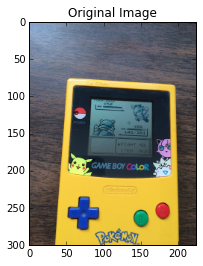

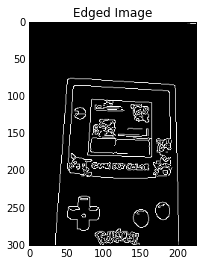

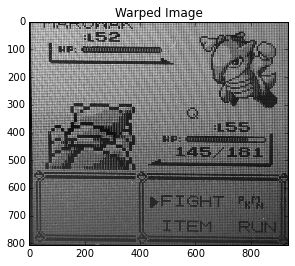

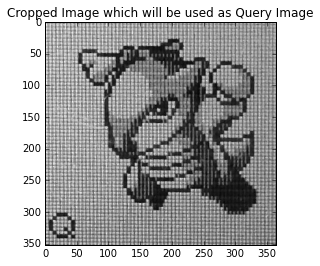

In [6]:
# 
# Extracting the query image from the Game Boy Screen
%matplotlib inline
# import the necessary packages
import imutils
from skimage import exposure
import numpy as np
import argparse
import cv2
from matplotlib import pyplot as plt

# # construct the argument parser and parse the arguments
# ap = argparse.ArgumentParser()
# ap.add_argument("-q", "--query", required = True,
# 	help = "Path to the query image")
# args = vars(ap.parse_args())

# load the query image, compute the ratio of the old height
# to the new height, clone it, and resize it
image = cv2.imread("C:/Users/tsrivas/Documents/PythonScripts/PyImage Blogs/Pokemon Image Search/query_marowak.jpg")
ratio = image.shape[0] / 300.0
orig = image.copy()
image = imutils.resize(image, height = 300)

# convert the image to grayscale, blur it, and find edges
# in the image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.bilateralFilter(gray, 11, 17, 17)
edged = cv2.Canny(gray, 30, 200)

# find contours in the edged image, keep only the largest
# ones, and initialize our screen contour
(cnts) = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[1]
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:10]
screenCnt = None

# loop over our contours
for c in cnts:
	# approximate the contour
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, 0.02 * peri, True)

	# if our approximated contour has four points, then
	# we can assume that we have found our screen
	if len(approx) == 4:
		screenCnt = approx
		break

# now that we have our screen contour, we need to determine
# the top-left, top-right, bottom-right, and bottom-left
# points so that we can later warp the image -- we'll start
# by reshaping our contour to be our finals and initializing
# our output rectangle in top-left, top-right, bottom-right,
# and bottom-left order
pts = screenCnt.reshape(4, 2)
rect = np.zeros((4, 2), dtype = "float32")

# the top-left point has the smallest sum whereas the
# bottom-right has the largest sum
s = pts.sum(axis = 1)
rect[0] = pts[np.argmin(s)]
rect[2] = pts[np.argmax(s)]

# compute the difference between the points -- the top-right
# will have the minumum difference and the bottom-left will
# have the maximum difference
diff = np.diff(pts, axis = 1)
rect[1] = pts[np.argmin(diff)]
rect[3] = pts[np.argmax(diff)]

# multiply the rectangle by the original ratio
rect *= ratio

# now that we have our rectangle of points, let's compute
# the width of our new image
(tl, tr, br, bl) = rect
widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))

# ...and now for the height of our new image
heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))

# take the maximum of the width and height values to reach
# our final dimensions
maxWidth = max(int(widthA), int(widthB))
maxHeight = max(int(heightA), int(heightB))

# construct our destination points which will be used to
# map the screen to a top-down, "birds eye" view
dst = np.array([
	[0, 0],
	[maxWidth - 1, 0],
	[maxWidth - 1, maxHeight - 1],
	[0, maxHeight - 1]], dtype = "float32")

# calculate the perspective transform matrix and warp
# the perspective to grab the screen
M = cv2.getPerspectiveTransform(rect, dst)
warp = cv2.warpPerspective(orig, M, (maxWidth, maxHeight))

# convert the warped image to grayscale and then adjust
# the intensity of the pixels to have minimum and maximum
# values of 0 and 255, respectively
warp = cv2.cvtColor(warp, cv2.COLOR_BGR2GRAY)
warp = exposure.rescale_intensity(warp, out_range = (0, 255))

# the pokemon we want to identify will be in the top-right
# corner of the warped image -- let's crop this region out
(h, w) = warp.shape
(dX, dY) = (int(w * 0.4), int(h * 0.45))
crop = warp[10:dY, w - dX:w - 10]

# save the cropped image to file
# cv2.imwrite("cropped.png", crop)

# show our images
# cv2.imshow("image", image)
# cv2.imshow("edge", edged)
# cv2.imshow("warp", imutils.resize(warp, height = 300))
# cv2.imshow("crop", imutils.resize(crop, height = 300))
# cv2.waitKey(0)
plt.figure(), plt.title("Original Image"), plt.imshow(imutils.opencv2matplotlib(image))
plt.figure(), plt.title("Edged Image"), plt.imshow(edged, 'gray')
plt.figure(), plt.title("Warped Image"), plt.imshow(warp, 'gray')
plt.figure(), plt.title("Cropped Image which will be used as Query Image"), plt.imshow(crop, 'gray')

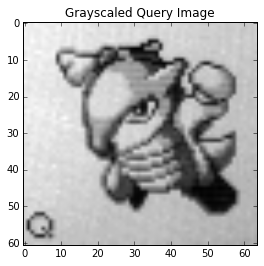

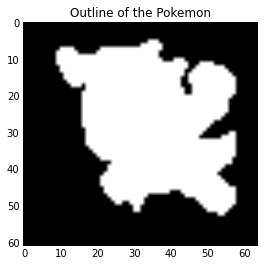

That pokemon is: MAROWAK


In [7]:
# -*- coding: utf-8 -*-
"""
Created on Fri May 12 14:55:46 2017
Search
@author: tsrivas
"""
%matplotlib inline
# import packages
from searcher import Searcher
from Zernike_Moments import ZernikeMoments
import imutils
import numpy as np
import argparse
import cPickle
import cv2
from matplotlib import pyplot as plt

# ap = argparse.ArgumentParser()
# ap.add_argument("-", "--index", required = True,
# 	help = "Path to where the index file will be stored")
# ap.add_argument("-q", "--query", required = True,
# 	help = "Path to the query image")
# args = vars(ap.parse_args())

# load the index
index = open("C:/Users/tsrivas/Documents/PythonScripts/PyImage Blogs/Pokemon Image Search/index/index.cpickle").read() 
index = cPickle.loads(index)
#print index

# Load the query image and pre-process it (this will be the cropped image)
image = cv2.imread("C:/Users/tsrivas/Documents/PythonScripts/PyImage Blogs/Pokemon Image Search/cropped.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = imutils.resize(image, width = 64)
plt.figure(), plt.imshow(image, 'gray'), plt.title("Grayscaled Query Image"), plt.show()

# threshold the image
thresh = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                               cv2.THRESH_BINARY_INV, 15, 10)
cv2.imshow("Thresh", thresh)                               
# initialize the outline image, find the outermost contour
# of the pokemon, then draw it
outline = np.zeros(image.shape, dtype = 'uint8')
(cnts) = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[1]
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
cv2.drawContours(outline, [cnts], -1, 255, -1)         
plt.figure(), plt.imshow(outline, 'gray'), plt.title("Outline of the Pokemon"), plt.show()
# cv2.imshow("Outline", outline)
# compute Zernike moments to characterize the shape of the outline image
desc = ZernikeMoments(21)
queryFeatures = desc.describe(outline)
#print queryFeatures
# perform the search         
searcher = Searcher(index)
results = searcher.search(queryFeatures)
#print results
print "That pokemon is: %s" % (results[0][1].upper())

# show our images
# cv2.imshow("Image", image)            
# cv2.waitKey(0) 

